In [2]:
import numpy as np
import geopandas as gpd


class Node:
    def __init__(self, points, idxs):
        self.points = points
        self.idxs = idxs
        self.left = None
        self.right = None
        self.radius = 0
        self.center = None


def build_tree(points, idxs):
    # Create a new node
    node = Node(points[idxs], idxs)

    # Compute the center and radius of the points
    node.center = points[idxs].mean(axis=0)
    node.radius = np.max(np.sum((points[idxs] - node.center) ** 2, axis=1))

    # If there is more than one point, split the node
    if len(idxs) > 1:
        # Compute the distance of each point to the center
        dists = np.sum((points[idxs] - node.center) ** 2, axis=1)

        # Find the point that is furthest from the center
        split_point = idxs[np.argmax(dists)]

        # Split the points into two groups
        left_idxs = idxs[dists <= dists[split_point]]
        right_idxs = idxs[dists > dists[split_point]]

        # Recursively build the tree
        node.left = build_tree(points, left_idxs)
        node.right = build_tree(points, right_idxs)

    return node


def query_radius(node, point, r):
    # Compute the distance of the point to the node's center
    dist = np.sum((point - node.center) ** 2)

    # If the distance is larger than the sum of the radius and r, there are no points within r
    if dist > node.radius + r**2:
        return []

    # If the node is a leaf node and the distance is less than r, return the point
    if node.left is None and dist <= r**2:
        return node.idxs.tolist()

    # If the node is not a leaf node, recursively query the child nodes
    points = []
    if node.left is not None:
        points += query_radius(node.left, point, r)
    if node.right is not None:
        points += query_radius(node.right, point, r)

    return points


def cluster_points(gdf, eps):
    # Extract x and y coordinates from the point geometries
    coords = gdf.geometry.apply(lambda geom: np.array(geom.coords[0])).tolist()
    coords = np.array(coords)

    # Build the tree
    tree = build_tree(coords, np.arange(len(coords)))

    # Query the tree for each point and create the clusters
    clusters = []
    for i in range(len(coords)):
        clusters.append(query_radius(tree, coords[i], eps))

    # Add the cluster labels to the GeoDataFrame
    gdf["cluster"] = clusters

    return gdf

In [36]:
from sklearn.cluster import DBSCAN


def set_substation_ids_dbscan(in_df, distance_crs, tol=5000):
    gdf = in_df.copy()
    # Convert the geometry to EPSG:3857
    gdf.geometry = gdf.geometry.to_crs(distance_crs)

    coords = gdf.geometry.apply(lambda geom: np.array(geom.coords[0])).to_list()

    # Perform DBSCAN on the coordinates
    db = DBSCAN(eps=tol, min_samples=1).fit(coords)

    # Add the cluster labels to the GeoDataFrame
    gdf["cluster"] = db.labels_

    return gdf

In [7]:
# original function
from tqdm import tqdm


def set_substations_ids(buses, distance_crs, tol=2000):
    ran_df = buses.copy()
    buses = ran_df

    buses["station_id"] = -1

    # create temporary series to execute distance calculations using m as reference distances
    temp_bus_geom = buses.geometry.to_crs(distance_crs)

    # set tqdm options for substation ids
    tqdm_kwargs_substation_ids = dict(
        ascii=False,
        unit=" buses",
        total=buses.shape[0],
        desc="Set substation ids ",
    )

    station_id = 0
    for i, row in tqdm(buses.iterrows(), **tqdm_kwargs_substation_ids):
        if buses.loc[i, "station_id"] >= 0:
            continue

        # get indeces of buses within tolerance
        close_nodes = np.flatnonzero(
            temp_bus_geom.distance(temp_bus_geom.loc[i]) <= tol
        )

        if len(close_nodes) == 1:
            # if only one substation is in tolerance, then the substation is the current one iì
            # Note that the node cannot be with substation_id >= 0, given the preliminary check
            # at the beginning of the for loop
            buses.loc[buses.index[i], "station_id"] = station_id
            # update station id
            station_id += 1
        else:
            # several substations in tolerance
            # get their ids
            subset_substation_ids = buses.loc[buses.index[close_nodes], "station_id"]
            # check if all substation_ids are negative (<0)
            all_neg = subset_substation_ids.max() < 0
            # check if at least a substation_id is negative (<0)
            some_neg = subset_substation_ids.min() < 0

            if all_neg:
                # when all substation_ids are negative, then this is a new substation id
                # set the current station_id and increment the counter
                buses.loc[buses.index[close_nodes], "station_id"] = station_id
                station_id += 1
            elif some_neg:
                # otherwise, when at least a substation_id is non-negative, then pick the first value
                # and set it to all the other substations within tolerance
                sub_id = -1
                for substation_id in subset_substation_ids:
                    if substation_id >= 0:
                        sub_id = substation_id
                        break
                buses.loc[buses.index[close_nodes], "station_id"] = sub_id

    return buses

In [9]:
# load NG raw buses data
ng_buses = gpd.read_file("/home/matin/Downloads/all_raw_substations.geojson")
distance_crs = "EPSG:3857"
tol = 5000
ng_buses_slow = set_substations_ids(ng_buses, distance_crs, tol=tol)
ng_buses_slow

Set substation ids : 100%|██████████| 188/188 [00:00<00:00, 4812.89 buses/s]


,id,tags.power,Type,Country,Area,tags.substation,tags.voltage,geometry,station_id
0,2000011529,substation,Node,NG,NaN,NaN,NaN,POINT (5.58060 6.35724),0
1,2075846568,substation,Node,NG,NaN,NaN,NaN,POINT (5.62399 6.32237),1
2,2161110201,substation,Node,NG,NaN,NaN,NaN,POINT (5.60758 6.31436),1
3,2161110983,substation,Node,NG,NaN,NaN,NaN,POINT (5.62487 6.32611),1
4,2161121796,substation,Node,NG,NaN,NaN,NaN,POINT (5.60564 6.29269),1
...,...,...,...,...,...,...,...,...,...
183,1072428088,substation,Way,NG,6790.0,NaN,NaN,POINT (7.03496 4.83221),3
184,1072428089,substation,Way,NG,5110.0,NaN,NaN,POINT (7.03539 4.83086),3
185,1085422075,substation,Way,NG,12590.0,NaN,NaN,POINT (5.37793 6.71533),131
186,1120308268,substation,Way,NG,5770.0,NaN,NaN,POINT (3.34876 6.49528),30


In [39]:
ng_buses_fast = set_substation_ids_dbscan(ng_buses, distance_crs, tol=tol)
ng_buses_fast

,id,tags.power,Type,Country,Area,tags.substation,tags.voltage,geometry,cluster
0,2000011529,substation,Node,NG,NaN,NaN,NaN,POINT (621229.016 709141.240),0
1,2075846568,substation,Node,NG,NaN,NaN,NaN,POINT (626059.603 705236.093),1
2,2161110201,substation,Node,NG,NaN,NaN,NaN,POINT (624233.039 704338.526),1
3,2161110983,substation,Node,NG,NaN,NaN,NaN,POINT (626157.642 705654.887),1
4,2161121796,substation,Node,NG,NaN,NaN,NaN,POINT (624017.525 701911.145),1
...,...,...,...,...,...,...,...,...,...
183,1072428088,substation,Way,NG,6790.0,NaN,NaN,POINT (783128.496 538558.458),3
184,1072428089,substation,Way,NG,5110.0,NaN,NaN,POINT (783176.293 538407.117),3
185,1085422075,substation,Way,NG,12590.0,NaN,NaN,POINT (598667.880 749264.472),131
186,1120308268,substation,Way,NG,5770.0,NaN,NaN,POINT (372781.891 724605.180),30


<Axes: >

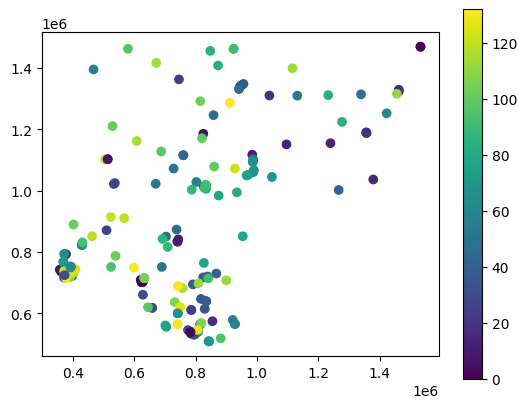

In [40]:
ng_buses_fast.plot(column="cluster", legend=True)

<Axes: >

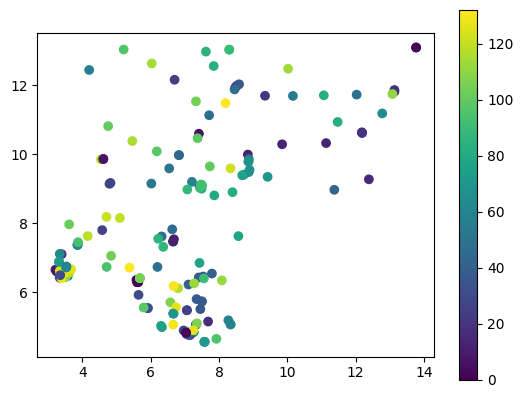

In [18]:
ng_buses_slow.plot(column="station_id", legend=True)

<Axes: >

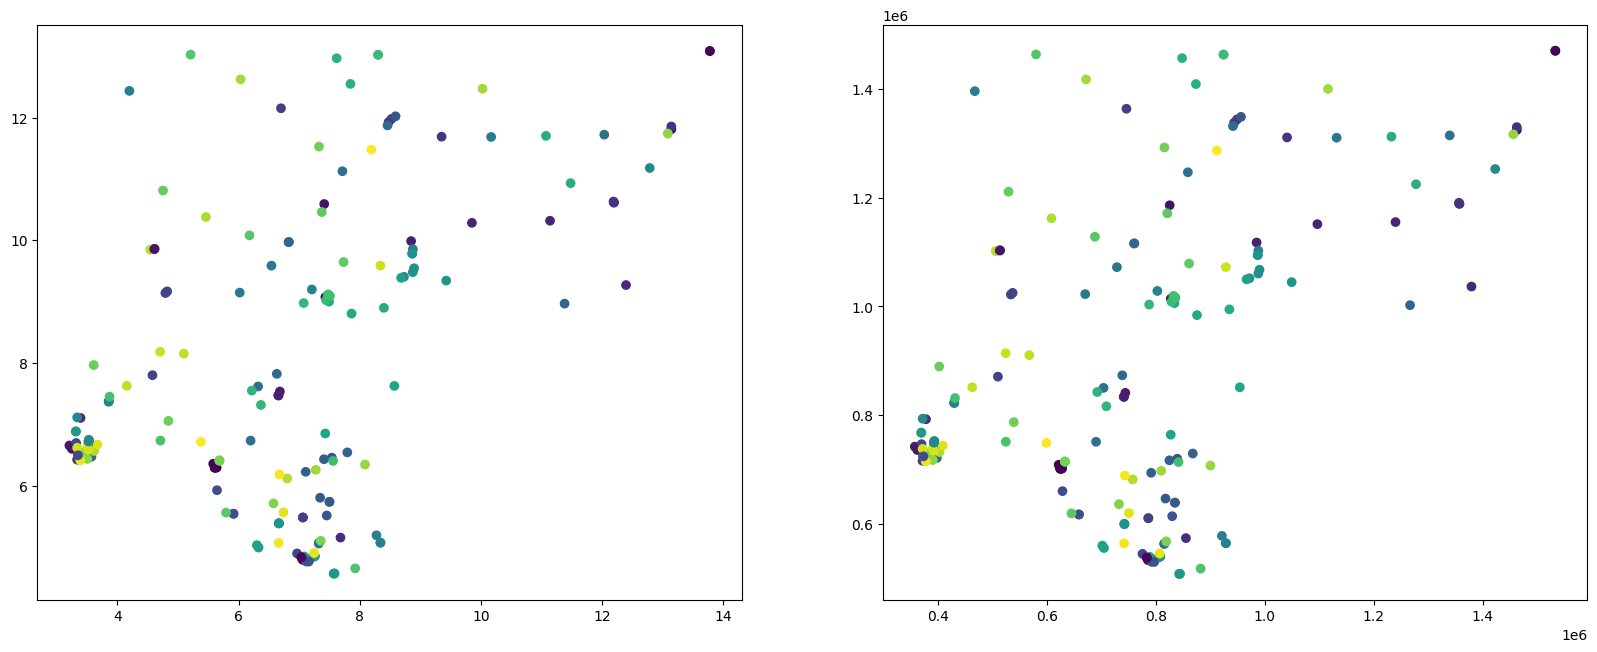

In [21]:
from matplotlib import pyplot as plt

# plot next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ng_buses_slow.plot(column="station_id", legend=False, ax=ax1)
ng_buses_fast.plot(column="cluster", legend=False, ax=ax2)

In [22]:
# load US raw buses data
us_buses = gpd.read_file("/home/matin/Downloads/all_raw_substations (1).geojson")
distance_crs = "EPSG:3857"
tol = 5000
us_buses_slow = set_substations_ids(us_buses, distance_crs, tol=tol)
us_buses_slow

Set substation ids : 100%|██████████| 51303/51303 [04:58<00:00, 171.59 buses/s]


,id,tags.power,Type,Country,Area,tags.substation,tags.voltage,geometry,station_id
0,94633368,substation,Node,US,NaN,NaN,NaN,POINT (-120.07688 38.20290),0
1,94735758,substation,Node,US,NaN,NaN,NaN,POINT (-120.11212 38.18658),0
2,105139113,substation,Node,US,NaN,NaN,NaN,POINT (-77.97839 40.20048),1
3,166253729,substation,Node,US,NaN,NaN,NaN,POINT (-88.59375 37.05841),2
4,263201045,substation,Node,US,NaN,NaN,NaN,POINT (-121.47793 37.71297),3
...,...,...,...,...,...,...,...,...,...
51298,1150241220,substation,Way,US,960.0,industrial,115000,POINT (-86.93040 32.52723),24085
51299,1150243744,substation,Way,US,630.0,NaN,40000,POINT (-83.29231 42.50230),15882
51300,1150248969,substation,Way,US,860.0,NaN,NaN,POINT (-87.43730 41.64413),1946
51301,1150252702,substation,Way,US,90.0,minor_distribution,NaN,POINT (-81.60765 30.46495),5324


In [23]:
us_buses_fast = set_substation_ids_dbscan(us_buses, distance_crs, tol=tol)
us_buses_fast

,id,tags.power,Type,Country,Area,tags.substation,tags.voltage,geometry,cluster
0,94633368,substation,Node,US,NaN,NaN,NaN,POINT (-13366897.472 4608129.158),0
1,94735758,substation,Node,US,NaN,NaN,NaN,POINT (-13370820.426 4605816.404),0
2,105139113,substation,Node,US,NaN,NaN,NaN,POINT (-8680514.556 4895118.763),1
3,166253729,substation,Node,US,NaN,NaN,NaN,POINT (-9862210.625 4447251.853),2
4,263201045,substation,Node,US,NaN,NaN,NaN,POINT (-13522861.355 4538956.752),3
...,...,...,...,...,...,...,...,...,...
51298,1150241220,substation,Way,US,960.0,industrial,115000,POINT (-9677048.306 3832718.166),22771
51299,1150243744,substation,Way,US,630.0,NaN,40000,POINT (-9272057.947 5236521.724),14700
51300,1150248969,substation,Way,US,860.0,NaN,NaN,POINT (-9733475.343 5107820.583),195
51301,1150252702,substation,Way,US,90.0,minor_distribution,NaN,POINT (-9084522.269 3563455.765),1485


<Axes: >

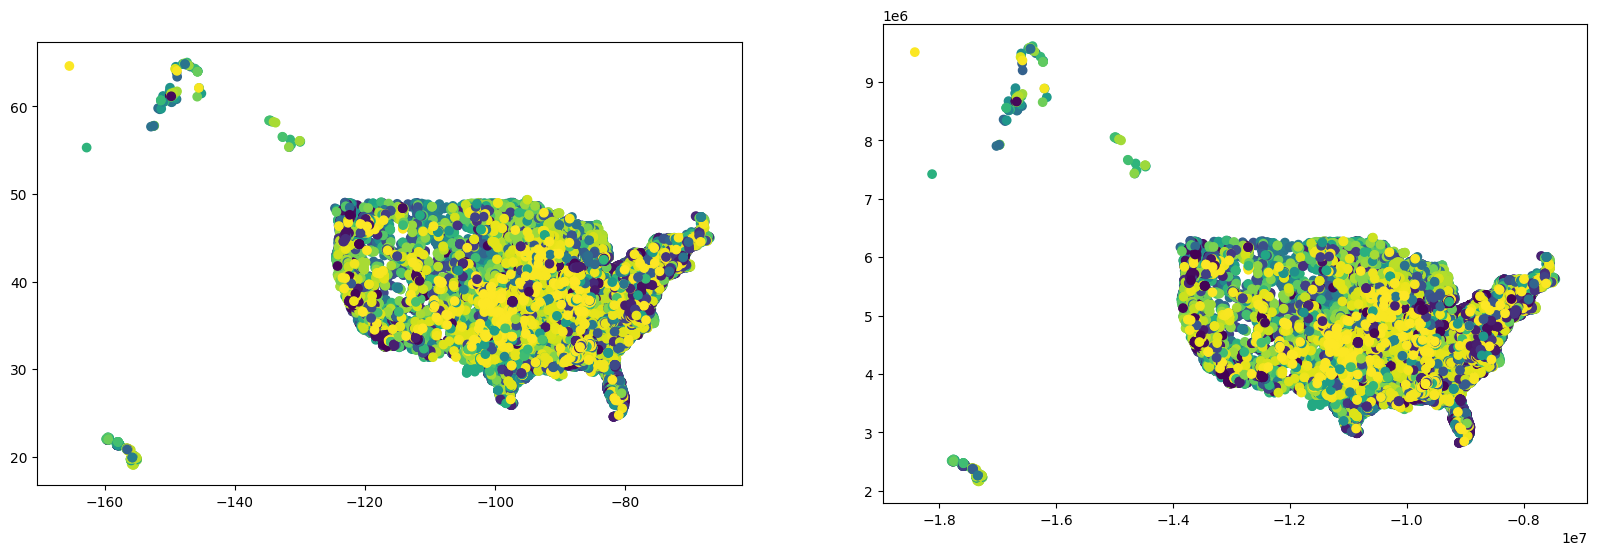

In [24]:
from matplotlib import pyplot as plt

# plot next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
us_buses_slow.plot(column="station_id", legend=False, ax=ax1)
us_buses_fast.plot(column="cluster", legend=False, ax=ax2)

In [28]:
# create a new df that has the columns cluster and station_id
ng_buses_fast["station_id"] = ng_buses_slow["station_id"]

In [29]:
# subset to geometry, substation_id, and cluster
ng_buses_fast = ng_buses_fast[["geometry", "station_id", "cluster"]]

In [43]:
# compare the two
ng_buses_fast["cluster"].equals(ng_buses_slow["station_id"])

True

<Axes: >

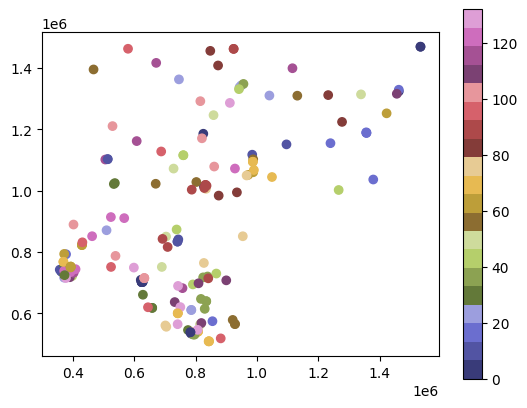

In [41]:
# plot, mark each cluster with a random color

In [44]:
us_buses_fast["cluster"].equals(us_buses_slow["station_id"])

False

0      0
1      0
2      1
3      2
4      3
      ..
95    81
96    82
97    83
98    84
99    85
Name: cluster, Length: 100, dtype: int64

In [49]:
# find the index where station_id start first to diverge from cluster

0            0
1            0
2            1
3            2
4            3
         ...  
51298    24085
51299    15882
51300     1946
51301     5324
51302     8093
Name: station_id, Length: 51303, dtype: int64

In [51]:
us_buses_fast["station_id"] = us_buses_slow["station_id"]

In [52]:
# drop row if cluster and station_id are the same
us_buses_fast = us_buses_fast[us_buses_fast["cluster"] != us_buses_fast["station_id"]]

In [54]:
# sort by cluster
us_buses_fast = us_buses_fast.sort_values(by="cluster")

In [55]:
us_buses_fast

,id,tags.power,Type,Country,Area,tags.substation,tags.voltage,geometry,cluster,station_id
13374,188039094,substation,Way,US,270.0,distribution,33000,POINT (-8196872.819 4962012.986),15,1745
24096,400029476,substation,Way,US,21590.0,NaN,NaN,POINT (-8243699.385 4970565.837),15,737
23948,397039282,substation,Way,US,320.0,NaN,NaN,POINT (-8236443.928 4978283.468),15,737
36399,742070304,substation,Way,US,570.0,NaN,NaN,POINT (-8214442.842 4977167.675),15,7701
36715,755645193,substation,Way,US,930.0,NaN,NaN,POINT (-8201028.710 4973926.656),15,1721
...,...,...,...,...,...,...,...,...,...,...
51290,1150241107,substation,Way,US,1040.0,transmission,115000;46000,POINT (-9631424.971 3890415.872),22769,24083
51289,1150241105,substation,Way,US,260.0,distribution,46000,POINT (-9632300.189 3888812.799),22769,24083
51291,1150241108,substation,Way,US,1370.0,generation,115000,POINT (-9631242.323 3890414.805),22769,24083
51296,1150241172,substation,Way,US,3250.0,distribution,115000,POINT (-9661248.500 3884644.857),22770,24084


In [57]:
# group by cluster and check if all the station_ids are the same
us_buses_fast.groupby("cluster")["station_id"].nunique()
# if nunique is 1, then all the station_ids are the same, drop all those rows
us_buses_fast = us_buses_fast.groupby("cluster").filter(
    lambda x: x["station_id"].nunique() > 1
)

In [58]:
us_buses_fast

,id,tags.power,Type,Country,Area,tags.substation,tags.voltage,geometry,cluster,station_id
13374,188039094,substation,Way,US,270.0,distribution,33000,POINT (-8196872.819 4962012.986),15,1745
24096,400029476,substation,Way,US,21590.0,NaN,NaN,POINT (-8243699.385 4970565.837),15,737
23948,397039282,substation,Way,US,320.0,NaN,NaN,POINT (-8236443.928 4978283.468),15,737
36399,742070304,substation,Way,US,570.0,NaN,NaN,POINT (-8214442.842 4977167.675),15,7701
36715,755645193,substation,Way,US,930.0,NaN,NaN,POINT (-8201028.710 4973926.656),15,1721
...,...,...,...,...,...,...,...,...,...,...
49486,1110962185,substation,Way,US,500.0,distribution,66000,POINT (-9284020.054 4192676.540),22005,23314
50358,1124444747,substation,Way,US,350.0,NaN,69000,POINT (-10864648.301 4139575.331),22365,23679
50351,1124329779,substation,Way,US,640.0,transmission,69000,POINT (-10862660.418 4135438.895),22365,23679
50350,1124329778,substation,Way,US,410.0,NaN,69000,POINT (-10860727.091 4142238.609),22365,23678


<Axes: >

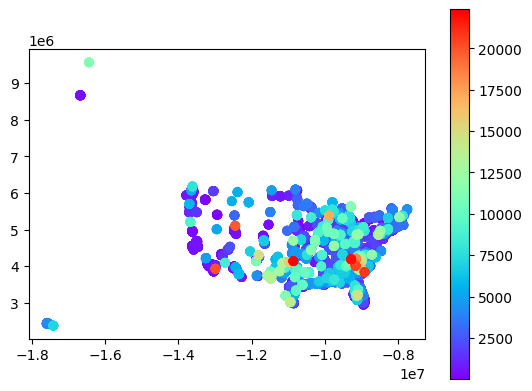

In [62]:
#  plot cluster simple
us_buses_fast.plot(column="cluster", legend=True, cmap="rainbow")

<Axes: >

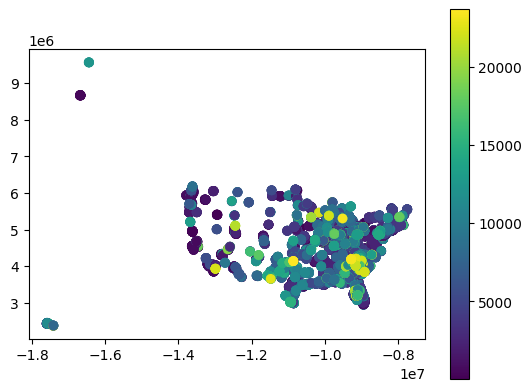

In [61]:
us_buses_fast.plot(column="station_id", legend=True)

<Axes: >

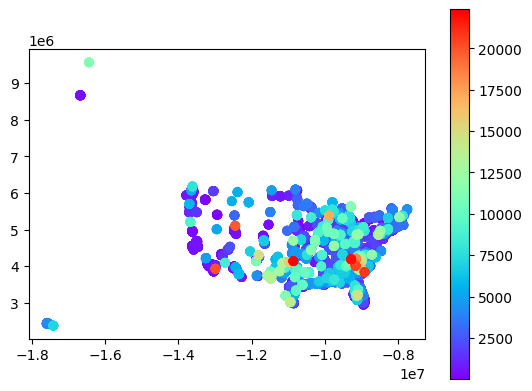

In [66]:
us_buses_fast.plot(column="cluster", legend=True, cmap="rainbow")

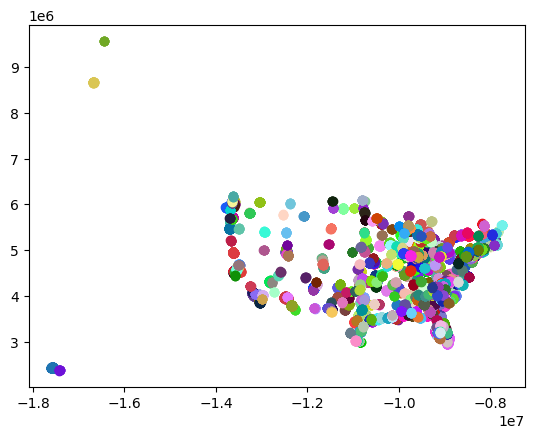

In [67]:
gdf = us_buses_fast
unique_clusters = gdf["cluster"].unique()
cluster_colors = {
    cluster: "#" + "".join(random.choices("0123456789ABCDEF", k=6))
    for cluster in unique_clusters
}

# Plot the DataFrame with cluster colors
fig, ax = plt.subplots()
for cluster, color in cluster_colors.items():
    cluster_data = gdf[gdf["cluster"] == cluster]
    cluster_data.plot(ax=ax, color=color)

plt.show()